<a href="https://colab.research.google.com/github/sumner-harris/Gomb-Net/blob/main/WSSe_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# basics
import os
import sys
import numpy as np

# plotting
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib import cm

# colab interactive plots and drive
drive = True
if 'google.colab' in sys.modules:
    from  google.colab import drive
    from google.colab import output
    drive.mount('/content/drive')
    output.enable_custom_widget_manager()
    drive = True
else:
    %matplotlib inline

# other imports
from scipy.ndimage import label, center_of_mass, gaussian_filter, zoom, uniform_filter
from scipy.spatial import KDTree
from scipy.interpolate import griddata
from scipy.stats import norm, gaussian_kde
from skimage.filters import threshold_otsu
from skimage.feature import blob_log

# for cropping function
if drive:
    print('installing DataGenSTEM')
    !pip install ase
    !git clone https://github.com/AustinHouston/DataGenSTEM.git
    sys.path.append('./DataGenSTEM/DataGenSTEM')
    import data_generator as dg

# for Gomb-Net
if drive:
    print('installing Gomb-Net')
    !git clone https://github.com/AustinHouston/Gomb-Net.git
    sys.path.append('./Gomb-Net/')
from GombNet.networks import *
from GombNet.loss_func import GombinatorialLoss
from GombNet.utils import *

import torch
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
installing DataGenSTEM
fatal: destination path 'DataGenSTEM' already exists and is not an empty directory.
installing Gomb-Net
fatal: destination path 'Gomb-Net' already exists and is not an empty directory.
CUDA is not available. Using CPU.


In [2]:
path = '/content/drive/MyDrive/results.pkl'

import pickle
with open(path, "rb") as f:
    results = pickle.load(f)

In [3]:
results[0].keys()

dict_keys(['image', 'mask', 'probability', 'centroids', 'se_top', 'se_bottom', 's_top', 's_bottom', 'w_top', 'w_bottom', 'map_2H', 'moire_sites', 'distance_arrays'])

0.15805022156573117
0.12000000000000002
0.0867579908675799
0.12210200927357033
0.11613876319758673


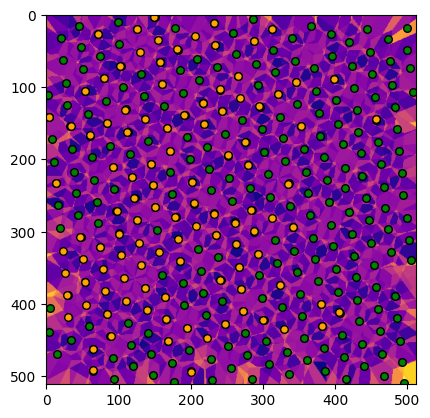

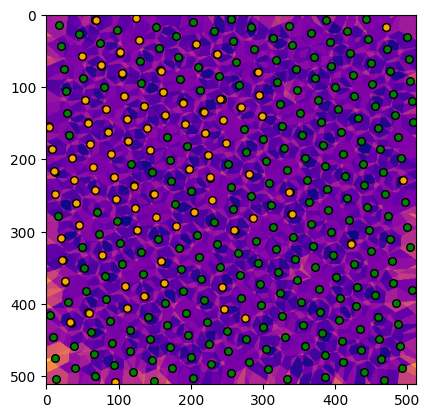

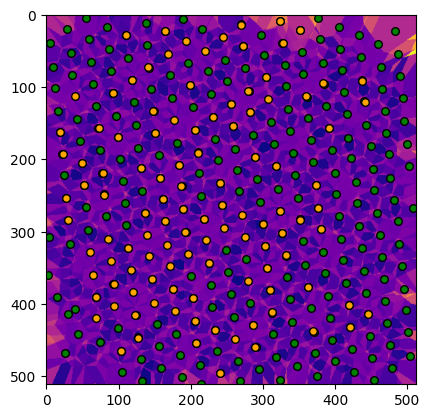

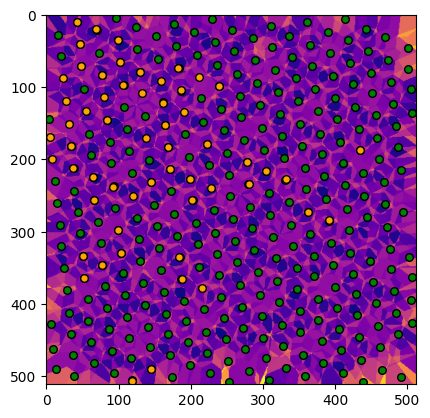

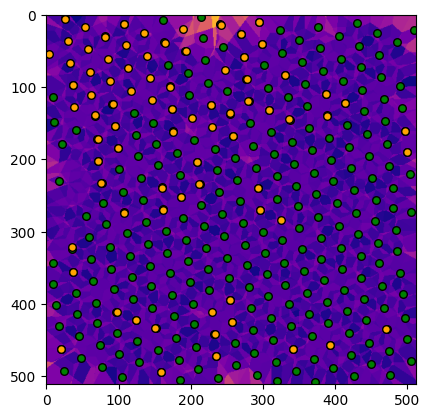

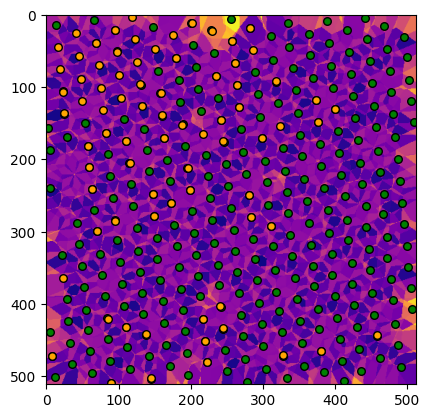

In [4]:
moire_values = []
top_s_moire_values = []
top_se_moire_values = []

# Create meshgrid for points
grid_density = 512
x = np.linspace(0, 512, grid_density)
y = np.linspace(0, 512, grid_density)
X, Y = np.meshgrid(x, y)
points = np.vstack((X.ravel(), Y.ravel())).T


for idx in results.keys():
    map_2H = results[idx]['map_2H']
    se = results[idx]['se_top']
    s = results[idx]['s_top']

    # print out the stoichiometry
    n_Se = len(se)
    n_S = len(s)
    x_stoic = n_Se / (n_S * (2 + n_Se/n_S))
    print(x_stoic)

    # Find where the atom positions (x,y) correlate to the moire value
    s_moire_sites_top = griddata((X.ravel(), Y.ravel()), map_2H.ravel(), (s[:, 1], s[:, 0]), method='cubic')
    se_moire_sites_top = griddata((X.ravel(), Y.ravel()), map_2H.ravel(), (se[:, 1], se[:, 0]), method='cubic')

    moire_values.append(map_2H.ravel())
    top_s_moire_values.append(s_moire_sites_top)
    top_se_moire_values.append(se_moire_sites_top)

    # plot the atoms on the moire map
    plt.figure()
    plt.imshow(map_2H, cmap='plasma')

    plt.scatter(s[:,1], s[:,0], c='green', edgecolor='k', s=30)
    plt.scatter(se[:,1], se[:,0], c='orange', edgecolor='k', s=30)



In [173]:
moire_values = np.concatenate([np.ravel(element) for element in moire_values])
top_s_moire_values = np.concatenate([np.ravel(element) for element in top_s_moire_values])
top_se_moire_values = np.concatenate([np.ravel(element) for element in top_se_moire_values])
top_chalchogen_values = np.append(top_s_moire_values, top_se_moire_values)

n_sample = len(top_se_moire_values)
random_sample = np.random.choice(top_chalchogen_values, size=n_sample, replace=False)

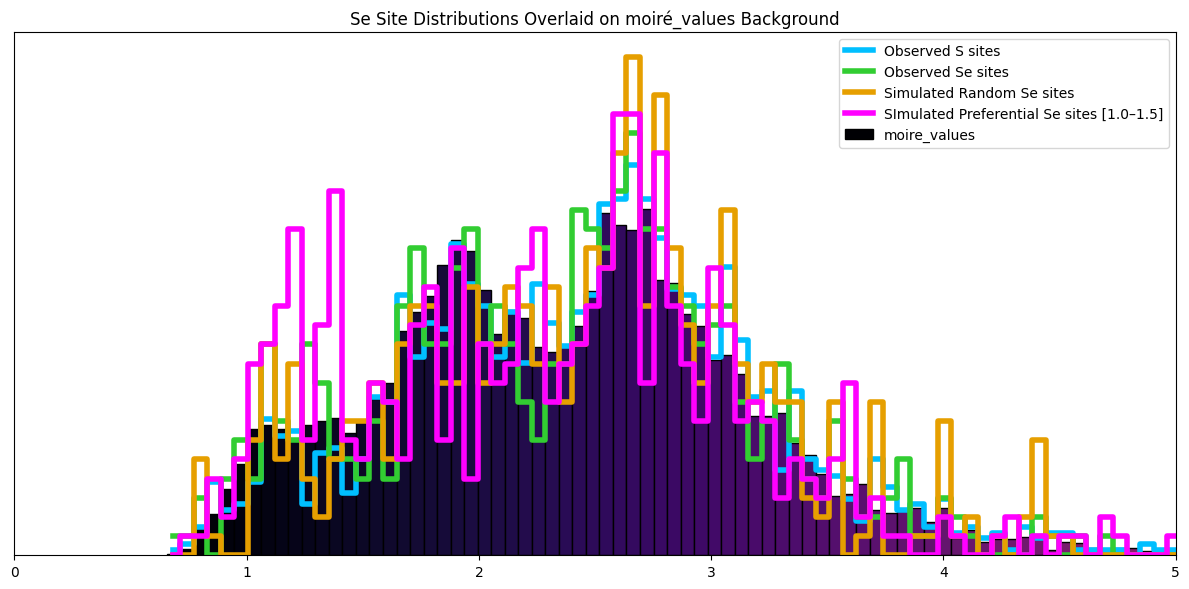

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

all_values = np.concatenate([
    moire_values,
    top_s_moire_values,
    top_se_moire_values,
    top_chalchogen_values
])
binedges   = np.histogram_bin_edges(all_values, bins=200)
bin_widths = np.diff(binedges)

# ── 2) COMPUTE HISTOGRAMS (COUNTS → DENSITIES) ───────────────────────────────────
hist_moire, _       = np.histogram(moire_values,        bins=binedges)
hist_top_s, _       = np.histogram(top_s_moire_values,  bins=binedges)
hist_top_se, _      = np.histogram(top_se_moire_values, bins=binedges)
random_sample       = np.random.choice(
    top_chalchogen_values,
    size=len(top_se_moire_values),
    replace=True
)
hist_top_chalc, _   = np.histogram(random_sample,      bins=binedges)

# convert counts → density (counts per unit x)
hist_moire_density     = hist_moire    / (hist_moire.sum()    * bin_widths)
hist_top_s_density     = hist_top_s    / (hist_top_s.sum()    * bin_widths)
hist_top_se_density    = hist_top_se   / (hist_top_se.sum()   * bin_widths)
hist_top_chalc_density = hist_top_chalc/ (hist_top_chalc.sum()* bin_widths)

# ── 3) SIMULATE “PREFERENTIAL” Se SUBSTITUTION ────────────────────────────────────
n_se = len(top_se_moire_values)

# weight vector: 2.5× preference for moiré-values in [1.0, 1.5]
weights = np.ones_like(top_chalchogen_values)
mask    = (top_chalchogen_values >= 1.0) & (top_chalchogen_values <= 1.5)
weights[mask] = 2.5

# to probabilities
probs = weights / weights.sum()

# draw preferential sample
sim_pref_values = np.random.choice(
    top_chalchogen_values,
    size=n_se,
    replace=True,
    p=probs
)

# histogram → density
hist_pref, _         = np.histogram(sim_pref_values, bins=binedges)
hist_pref_density    = hist_pref / (hist_pref.sum() * bin_widths)

# ── 4) PLOT ALL TOGETHER ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# background bar plot: moiré_values density with colormap
norm   = Normalize(vmin=moire_values.min(), vmax=moire_values.max())
colors = cm.inferno(norm(binedges[:-1]))
ax.bar(
    binedges[:-1],
    hist_moire_density,
    width=bin_widths,
    color=colors,
    edgecolor='k',
    alpha=1,
    label='moire_values'
)

# overlay line plots
ax.step(binedges[:-1], hist_top_s_density,    where='mid', color='deepskyblue', linewidth=4, label='Observed S sites')
ax.step(binedges[:-1], hist_top_se_density,   where='mid', color='limegreen',   linewidth=4, label='Observed Se sites')
ax.step(binedges[:-1], hist_top_chalc_density,where='mid', color='#E69F00',      linewidth=4, label='Simulated Random Se sites')
ax.step(binedges[:-1], hist_pref_density,     where='mid', color='magenta',      linewidth=4, label='SImulated Preferential Se sites [1.0–1.5]')

ax.set_xlim(0, 5)
ax.set_yticks([])
ax.legend(loc='upper right')
ax.set_title("Se Site Distributions Overlaid on moiré_values Background")
plt.tight_layout()
plt.show()


In [230]:
# prompt: compute the chi squared statistic between hist_top_chalc_density and hist_top_se_density and compute the p-value. Then do the same for hist_top_s_density and hist_top_chalc_density. Report whether the null hypothesis is rejected or not

import numpy as np
from scipy.stats import chi2_contingency,MonteCarloMethod

# Assuming hist_top_chalc_density, hist_top_se_density, and hist_top_s_density are defined as in the provided code.

#Subset the count data to remove the zeros on the very low and very high moire value sides, required to have valid contingency table
ob1 = hist_top_chalc[0:60]#_density[1:30]
ob2 = hist_top_se[0:60]#_density[1:30]
ob3 = hist_top_s[0:60]#_density[1:30]
biased_ob = hist_pref[0:60]

# Chi-squared test between hist_top_se and top_s
observed = np.stack([ob2, ob3])
mask = observed.sum(axis=0) > 0
observed =  observed[:, mask]
chi2_stat_1, p_value_1, dof_1, expected_1 = chi2_contingency(observed,correction=False,method=MonteCarloMethod(n_resamples=10000))

print("Chi-squared statistic (S vs Se):", chi2_stat_1)
print("P-value (S vs Se):", p_value_1)

alpha = 0.05  # significance level
if p_value_1 < alpha:
    print("Null hypothesis rejected (S vs Se.")
else:
    print("Null hypothesis not rejected (S vs Se).")

# Chi-squared test between hist_top_se and random Se sites
observed = np.stack([ob2, ob1])
mask = observed.sum(axis=0) > 0
observed =  observed[:, mask]
chi2_stat_2, p_value_2, dof_2, expected_2 = chi2_contingency(observed,correction=False,method=MonteCarloMethod(n_resamples=10000))

print("\nChi-squared statistic (Se vs random):", chi2_stat_2)
print("P-value (Se vs chalc):", p_value_2)

if p_value_2 < alpha:
    print("Null hypothesis rejected (Se vs random).")
else:
    print("Null hypothesis not rejected (Se vs random).")


# Chi-squared test between Se sites biases to moire lattice and random
observed = np.stack([biased_ob, ob1])
mask = observed.sum(axis=0) > 0
observed =  observed[:, mask]
chi2_stat_2, p_value_2, dof_2, expected_2 = chi2_contingency(observed,correction=False,method=MonteCarloMethod(n_resamples=10000))

print("\nChi-squared statistic (biased Se vs random):", chi2_stat_2)
print("P-value (biased Se vs random):", p_value_2)

if p_value_2 < alpha:
    print("Null hypothesis rejected (biased Se vs random).")
else:
    print("Null hypothesis not rejected (biased Se vs random).")

Chi-squared statistic (S vs Se): 52.77879083020319
P-value (S vs Se): 0.7002299770022997
Null hypothesis not rejected (S vs Se).

Chi-squared statistic (Se vs random): 56.568432496389846
P-value (Se vs chalc): 0.5853414658534146
Null hypothesis not rejected (Se vs random).

Chi-squared statistic (biased Se vs random): 80.01103056117194
P-value (biased Se vs random): 0.020597940205979402
Null hypothesis rejected (biased Se vs random).
